In [1]:
# Data Loading and Exploring
import pandas as pd
from pathlib import Path
from sodapy import Socrata

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px

# Data Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from sklearn.model_selection import GridSearchCV
import joblib

# Performance Measurement Metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# Custom Modules
from utils.data_loader import load_crime_dataset
from utils.maps import ChicagoMap

# Filter out Warnings
import warnings
warnings.filterwarnings("ignore")

# Visualization Configuration
sns.set_theme(style="ticks", color_codes=True)


In [2]:
# Location of stored dataset
dataset_path = Path('../datasets/chicago-crime-data.csv')

if dataset_path.exists():
    print(f"File found: {dataset_path.name}")
    crime_df = pd.read_csv(dataset_path)
    crime_df['date'] = pd.to_datetime(crime_df['date'])
else:
    load_crime_dataset()

File found: chicago-crime-data.csv


##### Data Preprocessing

In [3]:
def preprocess_crime_data(crime_df):
    # Step 1: Drop redundant columns
    crime_df.drop(columns=crime_df.columns[22:], axis=1, inplace=True)
    
    # Step 2: Detect and drop duplicates
    print(f"Duplicated rows detected: {sum(crime_df.duplicated())}")
    crime_df.drop_duplicates(inplace=True)
    
    # Step 3: Check and handle missing values
    print(f"Missing Values: {sum(crime_df.isna().sum())}")
    crime_df.dropna(inplace=True)
    
    # Step 4: Compute arrest rate and create encoding_dict
    encoding_dict = {
        primary_type: idx
        for idx, (primary_type, _) in enumerate(
            crime_df.groupby('primary_type')
            .apply(lambda g: ((g['arrest'].sum() / len(g)) * 100).round(2))
            .sort_values()
            .items()
        )
    }
    
    # Step 5: Encode 'primary_type' and update 'arrest' column
    crime_df['primary_type_encoded'] = crime_df['primary_type'].map(encoding_dict).fillna(-1).astype(int)
    crime_df['arrest'] = crime_df['arrest'].astype(int)
    
    # Step 6: Feature selection
    features = ['domestic', 'district', 'beat', 'community_area', 'ward',
                'x_coordinate', 'y_coordinate', 'latitude', 'longitude',
                'year', 'primary_type_encoded']
    target = 'arrest'
    
    X = crime_df[features]
    Y = crime_df[target]
    
    # Step 7: Scale features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, Y

##### Model Training and Tuning

In [4]:
def train_and_evaluate_random_forest(X, y):
    # Step 1: Split the data into training and testing sets
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print("Data split complete. Training set size:", X_train.shape, "Test set size:", X_test.shape)

    # Step 2: Define Random Forest model
    print("Defining the Random Forest model...")
    rf_model = RandomForestClassifier(random_state=42)

    # Step 3: Define parameter grid for GridSearchCV
    print("Defining parameter grid for GridSearchCV...")
    parameter_grid = {
        'rf_model__bootstrap': [True],
        'rf_model__max_depth': [80, 90, 100],
        'rf_model__n_estimators': [200, 500, 800],
        'rf_model__max_leaf_nodes': [20, 30, 40]
    }

    # Step 4: Create the pipeline with SMOTE for balancing class and Random Forest for classification
    print("Creating the pipeline with SMOTE and Random Forest...")
    smote = SMOTE(random_state=42)
    pipeline = imPipeline(steps=[
        ('smote', smote),
        ('rf_model', rf_model)
    ])

    # Step 5: Set up GridSearchCV
    print("Setting up GridSearchCV for hyperparameter tuning...")
    grid_search = GridSearchCV(estimator=pipeline, param_grid=parameter_grid, cv=3, n_jobs=-1)

    # Step 6: Fit the model with the training data
    print("Fitting the model with training data...")
    grid_search.fit(X_train, y_train)
    print("Model training complete. Best parameters found:", grid_search.best_params_)

    # Step 7: Predict on test data using the best model
    print("Making predictions on the test set...")
    rf_preds = grid_search.best_estimator_.predict(X_test)

    # Step 8: Create confusion matrix and display it using seaborn
    print("Generating confusion matrix...")
    cm = confusion_matrix(y_test, rf_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Greens')
    plt.title("Confusion Matrix")
    heatmap_path = "confusion_matrix.png"
    plt.savefig(heatmap_path)
    plt.show()
    print(f"Confusion matrix heatmap saved as '{heatmap_path}'.")

    # Step 9: Print classification report and accuracy
    print("Generating classification report and accuracy score...")
    report = classification_report(y_test, rf_preds)
    accuracy = accuracy_score(y_test, rf_preds)
    print("Random Forest Classification Report:")
    print(report)
    print("Accuracy:", accuracy)

    # Save classification report to a text file
    report_path = "classification_report.txt"
    with open(report_path, "w") as f:
        f.write("Random Forest Classification Report:\n")
        f.write(report)
        f.write("\n")
        f.write(f"Accuracy: {accuracy:.4f}\n")
    print(f"Classification report saved as '{report_path}'.")

    # Step 10: Save the trained model as a .pkl file
    print("Saving the model as a .pkl file...")
    model_path = "random_forest_model.pkl"
    joblib.dump(grid_search.best_estimator_, model_path)
    print(f"Model saved as '{model_path}'.")

In [6]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def train_and_evaluate_neural_network(X, y):
    # Step 1: Split the data into training and testing sets
    print("Splitting data into training and testing sets...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print("Data split complete. Training set size:", X_train.shape, "Test set size:", X_test.shape)

    # Step 2: Apply SMOTE to balance the classes in the training set
    print("Applying SMOTE for class balancing...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("SMOTE applied. Training set size after resampling:", X_train.shape)

    # Step 3: Normalize the features
    print("Normalizing features...")
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    print("Normalization complete.")

    # Step 4: Set up GPU configuration for TensorFlow
    print("Checking GPU availability...")
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        try:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)
            print("GPU is available and configured.")
        except RuntimeError as e:
            print("Error configuring GPU:", e)
    else:
        print("GPU not available. Training will use CPU.")

    # Step 5: Define the TensorFlow neural network model
    print("Defining the TensorFlow model...")
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')  # Adjust output layer for class count
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Step 6: Train the model
    print("Training the model...")
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
    print("Model training complete.")

    # Step 7: Evaluate the model on the test set
    print("Evaluating the model on the test set...")
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Step 8: Create confusion matrix and display it using seaborn
    print("Generating confusion matrix...")
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Step 9: Print classification report and accuracy
    print("Generating classification report and accuracy score...")
    print("Neural Network Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

    # Step 10: Save the trained model
    print("Saving the model...")
    model.save('neural_network_model.h5')
    print("Model saved as 'neural_network_model.h5'")


##### Report

Duplicated rows detected: 0
Missing Values: 102057
Splitting data into training and testing sets...
Data split complete. Training set size: (969004, 11) Test set size: (415288, 11)
Applying SMOTE for class balancing...
SMOTE applied. Training set size after resampling: (1653382, 11)
Normalizing features...
Normalization complete.
Checking GPU availability...
GPU not available. Training will use CPU.
Defining the TensorFlow model...
Training the model...
Epoch 1/10
41335/41335 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.7719 - loss: 0.4749 - val_accuracy: 0.4822 - val_loss: 0.7178
Epoch 2/10
41335/41335 ━━━━━━━━━━━━━━━━━━━━ 117s 3ms/step - accuracy: 0.7737 - loss: 0.4688 - val_accuracy: 0.4675 - val_loss: 0.7348
Epoch 3/10
41335/41335 ━━━━━━━━━━━━━━━━━━━━ 102s 2ms/step - accuracy: 0.7756 - loss: 0.4650 - val_accuracy: 0.5056 - val_loss: 0.7041
Epoch 4/10
41335/41335 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - accuracy: 0.7769 - loss: 0.4626 - val_accuracy: 0.5376 - val_loss: 0.6692
Epoch 5

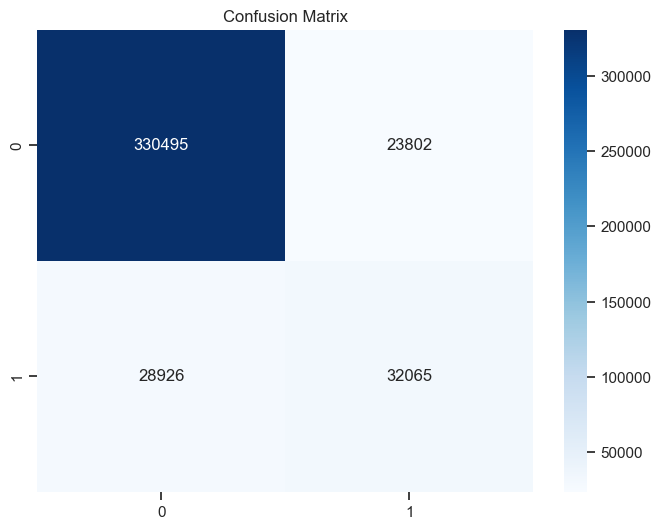

Generating classification report and accuracy score...
Neural Network Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.93      0.93    354297
           1       0.57      0.53      0.55     60991

    accuracy                           0.87    415288
   macro avg       0.75      0.73      0.74    415288
weighted avg       0.87      0.87      0.87    415288

Accuracy: 0.8730326905665466
Saving the model...
Model saved as 'neural_network_model.h5'


In [7]:
# Example usage
X, Y = preprocess_crime_data(crime_df)

train_and_evaluate_neural_network(X, Y)